
# Telecom X – Parte 2: Predicción de Cancelación (Churn)

Este notebook implementa **todo el pipeline** solicitado: preprocesamiento, codificación, balanceo opcional, normalización cuando corresponde, selección/correlación, entrenamiento de **dos+ modelos**, evaluación con métricas, y **explicabilidad** (importancias / coeficientes).

> Fecha de creación: 2025-08-20 00:31:39


In [2]:
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, RocCurveDisplay
)
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

# Modelos
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

# Opcional: SMOTE para balanceo
try:
    from imblearn.over_sampling import SMOTE
    IMBLEARN_AVAILABLE = True
except Exception:
    IMBLEARN_AVAILABLE = False

pd.set_option("display.max_columns", 200)
np.set_printoptions(suppress=True)


In [3]:

# === Configuración ===
# Nombre/columna objetivo de cancelación (ajústalo si tu columna se llama distinto, por ej. 'Churn', 'cancelacion', etc.)
TARGET_COL = 'Churn'  # <--- Cambia si tu dataset usa otro nombre

# Lista opcional de columnas ID u otras que quieras eliminar explícitamente
EXPLICIT_DROP_COLS = ['customerID', 'CustomerID', 'ClienteID', 'id', 'ID']  # edita según tu CSV

# Flag para usar SMOTE (si hay desbalanceo y la librería está disponible)
USE_SMOTE = True

# Proporción de test
TEST_SIZE = 0.2
RANDOM_STATE = 42
STRATIFY = True

# === Carga ===
CSV_PATH = ''  # Si estás en Colab, después de subir el archivo, asigna el nombre aquí. Ej: 'telecomx_clean.csv'

# Intento 1: usar ruta definida
if CSV_PATH and os.path.exists(CSV_PATH):
    df = pd.read_csv(CSV_PATH)
else:
    # Intento 2: Colab uploader
    try:
        import google.colab  # type: ignore
        from google.colab import files  # type: ignore
        print("Sube tu archivo CSV...")
        uploaded = files.upload()
        CSV_PATH = next(iter(uploaded.keys()))
        df = pd.read_csv(CSV_PATH)
    except Exception:
        # Intento 3: como fallback, busca algún CSV en el directorio actual
        candidates = [f for f in os.listdir('.') if f.lower().endswith('.csv')]
        if candidates:
            print(f"No se encontró CSV_PATH. Usando: {candidates[0]}")
            df = pd.read_csv(candidates[0])
            CSV_PATH = candidates[0]
        else:
            raise FileNotFoundError("No se encontró un CSV. Define CSV_PATH o sube el archivo en Colab.")

print(f"CSV cargado desde: {CSV_PATH}")
print(df.shape)
display(df.head())


Sube tu archivo CSV...


Saving telecomx_clean (2).csv to telecomx_clean (2).csv
CSV cargado desde: telecomx_clean (2).csv
(7267, 33)


,customerID,Churn,customer,phone,internet,account,gender,SeniorCitizen,Partner,Dependents,tenure,monthly_charges,total_charges,cuentas_diarias,gender.1,SeniorCitizen.1,Partner.1,Dependents.1,tenure.1,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,gender.2,SeniorCitizen.2,Partner.2,Dependents.2,tenure.2
0,0002-ORFBO,No,"{'gender': 'Female', 'SeniorCitizen': 0, 'Part...","{'PhoneService': 'Yes', 'MultipleLines': 'No'}","{'InternetService': 'DSL', 'OnlineSecurity': '...","{'Contract': 'One year', 'PaperlessBilling': '...",Female,0,Yes,Yes,9,65.6,593.30,2.186667,Female,0,Yes,Yes,9,Yes,No,DSL,No,Yes,No,Yes,Yes,No,Female,0,Yes,Yes,9
1,0003-MKNFE,No,"{'gender': 'Male', 'SeniorCitizen': 0, 'Partne...","{'PhoneService': 'Yes', 'MultipleLines': 'Yes'}","{'InternetService': 'DSL', 'OnlineSecurity': '...","{'Contract': 'Month-to-month', 'PaperlessBilli...",Male,0,No,No,9,59.9,542.40,1.996667,Male,0,No,No,9,Yes,Yes,DSL,No,No,No,No,No,Yes,Male,0,No,No,9
2,0004-TLHLJ,Yes,"{'gender': 'Male', 'SeniorCitizen': 0, 'Partne...","{'PhoneService': 'Yes', 'MultipleLines': 'No'}","{'InternetService': 'Fiber optic', 'OnlineSecu...","{'Contract': 'Month-to-month', 'PaperlessBilli...",Male,0,No,No,4,73.9,280.85,2.463333,Male,0,No,No,4,Yes,No,Fiber optic,No,No,Yes,No,No,No,Male,0,No,No,4
3,0011-IGKFF,Yes,"{'gender': 'Male', 'SeniorCitizen': 1, 'Partne...","{'PhoneService': 'Yes', 'MultipleLines': 'No'}","{'InternetService': 'Fiber optic', 'OnlineSecu...","{'Contract': 'Month-to-month', 'PaperlessBilli...",Male,1,Yes,No,13,98.0,1237.85,3.266667,Male,1,Yes,No,13,Yes,No,Fiber optic,No,Yes,Yes,No,Yes,Yes,Male,1,Yes,No,13
4,0013-EXCHZ,Yes,"{'gender': 'Female', 'SeniorCitizen': 1, 'Part...","{'PhoneService': 'Yes', 'MultipleLines': 'No'}","{'InternetService': 'Fiber optic', 'OnlineSecu...","{'Contract': 'Month-to-month', 'PaperlessBilli...",Female,1,Yes,No,3,83.9,267.40,2.796667,Female,1,Yes,No,3,Yes,No,Fiber optic,No,No,No,Yes,Yes,No,Female,1,Yes,No,3


In [4]:

df_clean = df.copy()

# 1) Drop explícito
to_drop = [c for c in EXPLICIT_DROP_COLS if c in df_clean.columns]

# 2) Heurística: columnas con ratio de unicidad muy alto (e.g., > 0.98)
uniqueness = df_clean.nunique() / len(df_clean)
heuristic_drop = [col for col, ratio in uniqueness.items() if ratio > 0.98]
to_drop = list(dict.fromkeys(to_drop + heuristic_drop))  # unique order-preserving

print("Columnas a eliminar:", to_drop)
df_clean = df_clean.drop(columns=to_drop, errors='ignore')

print(df_clean.shape)
display(df_clean.head())


Columnas a eliminar: ['customerID']
(7267, 32)


,Churn,customer,phone,internet,account,gender,SeniorCitizen,Partner,Dependents,tenure,monthly_charges,total_charges,cuentas_diarias,gender.1,SeniorCitizen.1,Partner.1,Dependents.1,tenure.1,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,gender.2,SeniorCitizen.2,Partner.2,Dependents.2,tenure.2
0,No,"{'gender': 'Female', 'SeniorCitizen': 0, 'Part...","{'PhoneService': 'Yes', 'MultipleLines': 'No'}","{'InternetService': 'DSL', 'OnlineSecurity': '...","{'Contract': 'One year', 'PaperlessBilling': '...",Female,0,Yes,Yes,9,65.6,593.30,2.186667,Female,0,Yes,Yes,9,Yes,No,DSL,No,Yes,No,Yes,Yes,No,Female,0,Yes,Yes,9
1,No,"{'gender': 'Male', 'SeniorCitizen': 0, 'Partne...","{'PhoneService': 'Yes', 'MultipleLines': 'Yes'}","{'InternetService': 'DSL', 'OnlineSecurity': '...","{'Contract': 'Month-to-month', 'PaperlessBilli...",Male,0,No,No,9,59.9,542.40,1.996667,Male,0,No,No,9,Yes,Yes,DSL,No,No,No,No,No,Yes,Male,0,No,No,9
2,Yes,"{'gender': 'Male', 'SeniorCitizen': 0, 'Partne...","{'PhoneService': 'Yes', 'MultipleLines': 'No'}","{'InternetService': 'Fiber optic', 'OnlineSecu...","{'Contract': 'Month-to-month', 'PaperlessBilli...",Male,0,No,No,4,73.9,280.85,2.463333,Male,0,No,No,4,Yes,No,Fiber optic,No,No,Yes,No,No,No,Male,0,No,No,4
3,Yes,"{'gender': 'Male', 'SeniorCitizen': 1, 'Partne...","{'PhoneService': 'Yes', 'MultipleLines': 'No'}","{'InternetService': 'Fiber optic', 'OnlineSecu...","{'Contract': 'Month-to-month', 'PaperlessBilli...",Male,1,Yes,No,13,98.0,1237.85,3.266667,Male,1,Yes,No,13,Yes,No,Fiber optic,No,Yes,Yes,No,Yes,Yes,Male,1,Yes,No,13
4,Yes,"{'gender': 'Female', 'SeniorCitizen': 1, 'Part...","{'PhoneService': 'Yes', 'MultipleLines': 'No'}","{'InternetService': 'Fiber optic', 'OnlineSecu...","{'Contract': 'Month-to-month', 'PaperlessBilli...",Female,1,Yes,No,3,83.9,267.40,2.796667,Female,1,Yes,No,3,Yes,No,Fiber optic,No,No,No,Yes,Yes,No,Female,1,Yes,No,3


In [6]:
# Definir target
TARGET_COL = "Churn"

assert TARGET_COL in df_clean.columns, f"No se encontró la columna objetivo '{TARGET_COL}' en el CSV."

y_raw = df_clean[TARGET_COL].copy()
X_raw = df_clean.drop(columns=[TARGET_COL])

# Conversión de la variable objetivo a 0/1 si viene como string
if y_raw.dtype == 'O':
    # Normalizar texto
    y_norm = y_raw.astype(str).str.strip().str.lower()

    # Diccionario de mapeo extendido
    mapping = {
        'yes':1,'no':0,
        'si':1,'sí':1,
        'nao':0,'não':0,
        'true':1,'false':0,
        'cancelado':1,'activo':0,
        'churn':1,'no churn':0
    }

    y = y_norm.map(mapping)

    # Chequear valores no reconocidos
    if y.isna().any():
        print("⚠️ Valores no reconocidos en 'Churn':")
        print(y_norm[y.isna()].value_counts(dropna=False))

        # Opción: eliminar filas con target no válido
        y = y.dropna()
        X_raw = X_raw.loc[y.index]

else:
    # Si ya es numérica, validar que sea binaria
    unique_vals = sorted(pd.unique(y_raw))
    if set(unique_vals) <= {0,1}:
        y = y_raw.astype(int)
    else:
        raise ValueError("La columna objetivo es numérica pero no binaria 0/1. Normaliza manualmente.")

print("✅ Distribución de la variable objetivo (y):")
print(pd.Series(y).value_counts(dropna=False, normalize=True))


⚠️ Valores no reconocidos en 'Churn':
Churn
nan    224
Name: count, dtype: int64
✅ Distribución de la variable objetivo (y):
Churn
0.0    0.73463
1.0    0.26537
Name: proportion, dtype: float64


Conteo de clases (0=No Churn, 1=Churn):


,count
Churn,
0.0,5174
1.0,1869



Proporción de clases:


,percent_%
Churn,
0.0,73.46
1.0,26.54


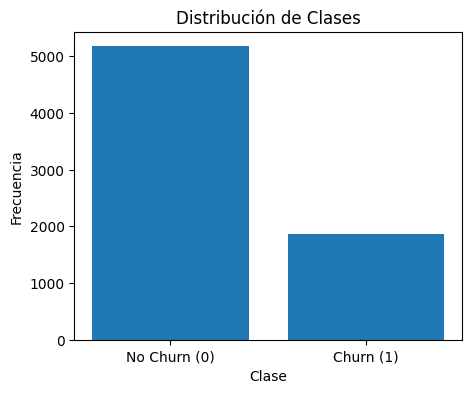

In [7]:

cls_counts = pd.Series(y).value_counts().sort_index()
cls_ratio = cls_counts / cls_counts.sum()
print("Conteo de clases (0=No Churn, 1=Churn):")
display(cls_counts.to_frame('count'))
print("\nProporción de clases:")
display((cls_ratio*100).round(2).to_frame('percent_%'))

# Visual simple
plt.figure(figsize=(5,4))
plt.bar(['No Churn (0)','Churn (1)'], cls_counts.values)
plt.title('Distribución de Clases')
plt.xlabel('Clase')
plt.ylabel('Frecuencia')
plt.show()


In [8]:

X = X_raw.copy()

numeric_cols = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = X.select_dtypes(include=['object','category']).columns.tolist()

# Opcional: trata como categóricas columnas numéricas con muy pocos valores únicos (e.g., <= 10)
for col in numeric_cols.copy():
    if X[col].nunique() <= 10 and X[col].dtype != 'float':
        categorical_cols.append(col)
        numeric_cols.remove(col)

print("Columnas numéricas:", numeric_cols)
print("Columnas categóricas:", categorical_cols)


Columnas numéricas: ['tenure', 'monthly_charges', 'total_charges', 'cuentas_diarias', 'tenure.1', 'tenure.2']
Columnas categóricas: ['customer', 'phone', 'internet', 'account', 'gender', 'Partner', 'Dependents', 'gender.1', 'Partner.1', 'Dependents.1', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'gender.2', 'Partner.2', 'Dependents.2', 'SeniorCitizen', 'SeniorCitizen.1', 'SeniorCitizen.2']


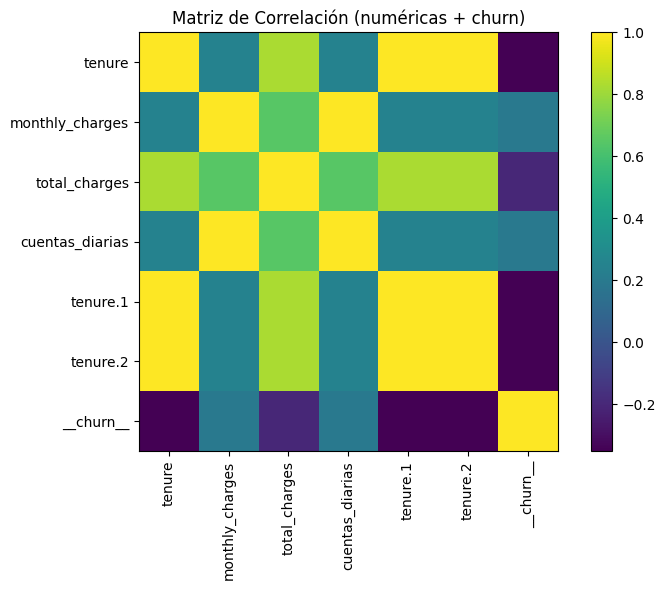

/tmp/ipython-input-4089181689.py:27: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([data0, data1], labels=['No Churn (0)', 'Churn (1)'])


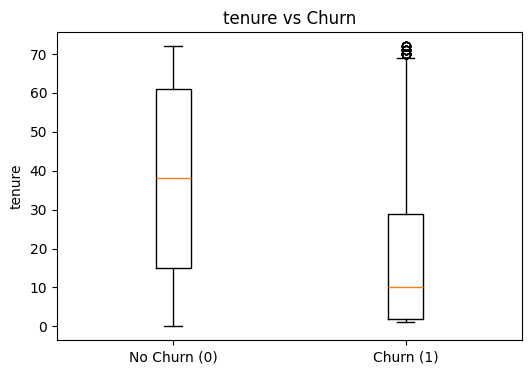

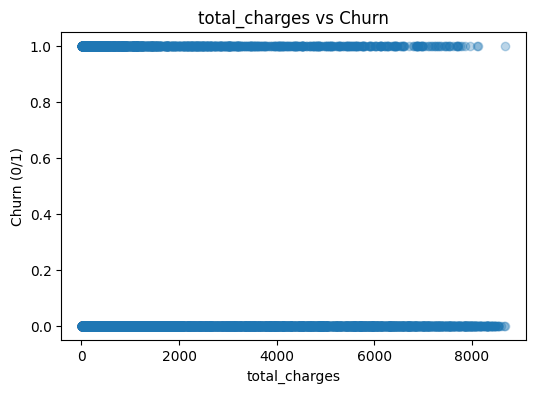

In [9]:

# Unir X numéricas con y para analizar correlaciones
num_for_corr = X[numeric_cols].copy()
num_for_corr['__churn__'] = y.values

corr = num_for_corr.corr(numeric_only=True)
plt.figure(figsize=(8,6))
plt.imshow(corr, interpolation='nearest')
plt.title('Matriz de Correlación (numéricas + churn)')
plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
plt.yticks(range(len(corr.index)), corr.index)
plt.colorbar()
plt.tight_layout()
plt.show()

# Boxplot: tenure vs churn (si existe)
candidate_tenure = None
for cand in ['tenure','TiempoContrato','MesesDeContrato','contract_months']:
    if cand in X.columns:
        candidate_tenure = cand
        break

if candidate_tenure is not None:
    plt.figure(figsize=(6,4))
    # Boxplots separados por clase
    data0 = X[y==0][candidate_tenure].dropna()
    data1 = X[y==1][candidate_tenure].dropna()
    plt.boxplot([data0, data1], labels=['No Churn (0)', 'Churn (1)'])
    plt.title(f'{candidate_tenure} vs Churn')
    plt.ylabel(candidate_tenure)
    plt.show()
else:
    print("No se encontró una columna de 'tenure' común. Ajusta los nombres en el código si aplica.")

# Scatter: TotalCharges vs churn (si existe)
candidate_total = None
for cand in ['TotalCharges','TotalGasto','GastoTotal','total_charges']:
    if cand in X.columns:
        candidate_total = cand
        break

if candidate_total is not None:
    plt.figure(figsize=(6,4))
    plt.scatter(X[candidate_total], y, alpha=0.3)
    plt.title(f'{candidate_total} vs Churn')
    plt.xlabel(candidate_total)
    plt.ylabel('Churn (0/1)')
    plt.show()
else:
    print("No se encontró una columna de 'TotalCharges' común. Ajusta los nombres en el código si aplica.")


In [10]:

stratify_arg = y if STRATIFY else None
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=stratify_arg
)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)


(5634, 31) (1409, 31) (5634,) (1409,)


In [11]:

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

numeric_transformer_no_scale = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median"))
])

numeric_transformer_with_scale = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

pre_no_scale = ColumnTransformer(
    transformers=[
        ("cat", categorical_transformer, categorical_cols),
        ("num", numeric_transformer_no_scale, numeric_cols)
    ],
    remainder="drop"
)

pre_with_scale = ColumnTransformer(
    transformers=[
        ("cat", categorical_transformer, categorical_cols),
        ("num", numeric_transformer_with_scale, numeric_cols)
    ],
    remainder="drop"
)


In [12]:

def add_smote_to_pipeline(pipeline_steps):
    if USE_SMOTE and IMBLEARN_AVAILABLE:
        from imblearn.pipeline import Pipeline as ImbPipeline
        smote = SMOTE(random_state=RANDOM_STATE)
        return ImbPipeline(pipeline_steps[:1] + [("smote", smote)] + pipeline_steps[1:])  # preprocessor -> SMOTE -> model
    else:
        return Pipeline(pipeline_steps)

print("SMOTE disponible:", IMBLEARN_AVAILABLE, "| USE_SMOTE:", USE_SMOTE)


SMOTE disponible: True | USE_SMOTE: True


In [13]:

models = {}

# 1) Regresión Logística (con escala)
clf_lr = LogisticRegression(max_iter=200, class_weight=None, random_state=RANDOM_STATE, n_jobs=None, solver='lbfgs')
pipe_lr = add_smote_to_pipeline([("pre", pre_with_scale), ("clf", clf_lr)])
models["LogisticRegression"] = pipe_lr

# 2) Random Forest (sin escala)
clf_rf = RandomForestClassifier(
    n_estimators=300, max_depth=None, random_state=RANDOM_STATE, n_jobs=-1, class_weight=None
)
pipe_rf = add_smote_to_pipeline([("pre", pre_no_scale), ("clf", clf_rf)])
models["RandomForest"] = pipe_rf

# 3) SVM (opcional, con escala)
clf_svm = SVC(kernel='rbf', probability=True, random_state=RANDOM_STATE)
pipe_svm = add_smote_to_pipeline([("pre", pre_with_scale), ("clf", clf_svm)])
models["SVM_rbf"] = pipe_svm

# 4) KNN (opcional, con escala)
clf_knn = KNeighborsClassifier(n_neighbors=15)
pipe_knn = add_smote_to_pipeline([("pre", pre_with_scale), ("clf", clf_knn)])
models["KNN_k15"] = pipe_knn

list(models.keys())


['LogisticRegression', 'RandomForest', 'SVM_rbf', 'KNN_k15']


=== Entrenando LogisticRegression ===


/usr/local/lib/python3.12/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Accuracy: 0.7587 | Precision: 0.5383 | Recall: 0.6390 | F1: 0.5844
Matriz de confusión:
 [[830 205]
 [135 239]]

Classification Report:
               precision    recall  f1-score   support

         0.0       0.86      0.80      0.83      1035
         1.0       0.54      0.64      0.58       374

    accuracy                           0.76      1409
   macro avg       0.70      0.72      0.71      1409
weighted avg       0.77      0.76      0.76      1409



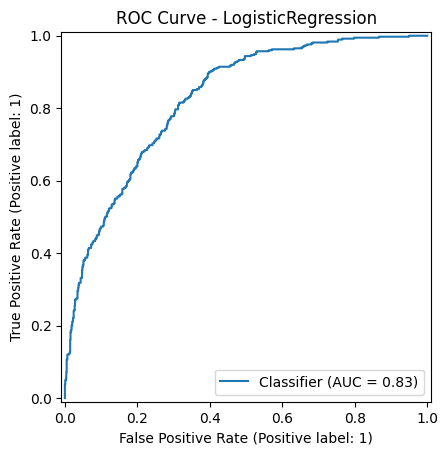


=== Entrenando RandomForest ===


/usr/local/lib/python3.12/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Accuracy: 0.7757 | Precision: 0.6036 | Recall: 0.4519 | F1: 0.5168
Matriz de confusión:
 [[924 111]
 [205 169]]

Classification Report:
               precision    recall  f1-score   support

         0.0       0.82      0.89      0.85      1035
         1.0       0.60      0.45      0.52       374

    accuracy                           0.78      1409
   macro avg       0.71      0.67      0.69      1409
weighted avg       0.76      0.78      0.76      1409



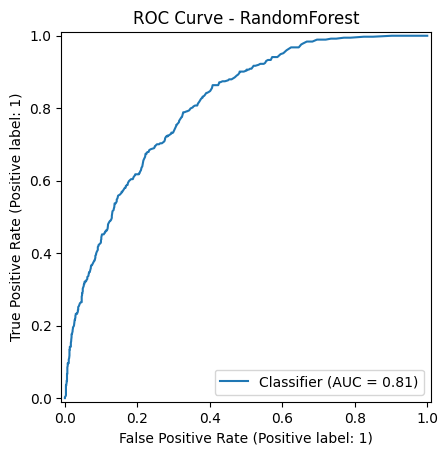


=== Entrenando SVM_rbf ===


/usr/local/lib/python3.12/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Accuracy: 0.7459 | Precision: 0.5145 | Recall: 0.7567 | F1: 0.6126
Matriz de confusión:
 [[768 267]
 [ 91 283]]

Classification Report:
               precision    recall  f1-score   support

         0.0       0.89      0.74      0.81      1035
         1.0       0.51      0.76      0.61       374

    accuracy                           0.75      1409
   macro avg       0.70      0.75      0.71      1409
weighted avg       0.79      0.75      0.76      1409



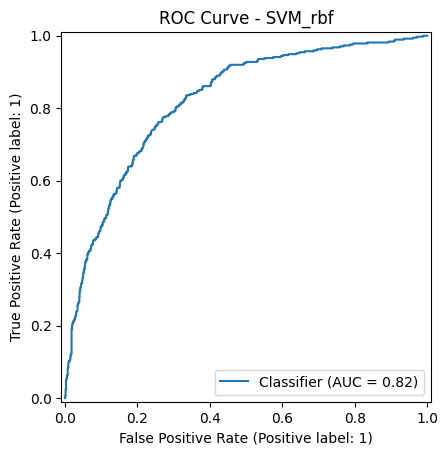


=== Entrenando KNN_k15 ===


/usr/local/lib/python3.12/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Accuracy: 0.6295 | Precision: 0.4066 | Recall: 0.8610 | F1: 0.5523
Matriz de confusión:
 [[565 470]
 [ 52 322]]

Classification Report:
               precision    recall  f1-score   support

         0.0       0.92      0.55      0.68      1035
         1.0       0.41      0.86      0.55       374

    accuracy                           0.63      1409
   macro avg       0.66      0.70      0.62      1409
weighted avg       0.78      0.63      0.65      1409



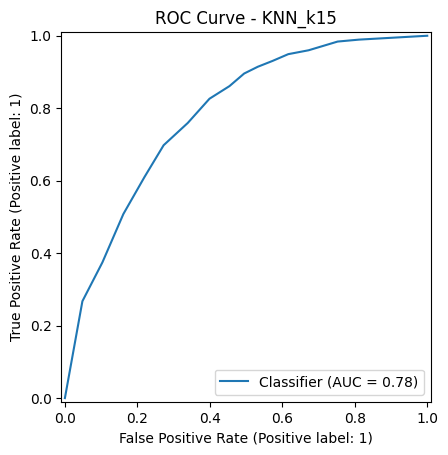

In [14]:

results = {}

for name, model in models.items():
    print(f"\n=== Entrenando {name} ===")
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    # Proba / scores para ROC
    if hasattr(model, "predict_proba"):
        y_scores = model.predict_proba(X_test)[:,1]
    elif hasattr(model, "decision_function"):
        y_scores = model.decision_function(X_test)
    else:
        y_scores = None

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, zero_division=0)
    rec = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    cm = confusion_matrix(y_test, y_pred)
    cr = classification_report(y_test, y_pred, zero_division=0, output_dict=False)

    results[name] = {"accuracy": acc, "precision": prec, "recall": rec, "f1": f1, "cm": cm, "report": cr, "y_scores": y_scores}

    print(f"Accuracy: {acc:.4f} | Precision: {prec:.4f} | Recall: {rec:.4f} | F1: {f1:.4f}")
    print("Matriz de confusión:\n", cm)
    print("\nClassification Report:\n", cr)

    # ROC
    if y_scores is not None:
        RocCurveDisplay.from_predictions(y_test, y_scores)
        plt.title(f"ROC Curve - {name}")
        plt.show()


,accuracy,precision,recall,f1
SVM_rbf,0.745919,0.514545,0.756684,0.612554
LogisticRegression,0.758694,0.538288,0.639037,0.584352
KNN_k15,0.629524,0.406566,0.860963,0.552316
RandomForest,0.775727,0.603571,0.451872,0.516820


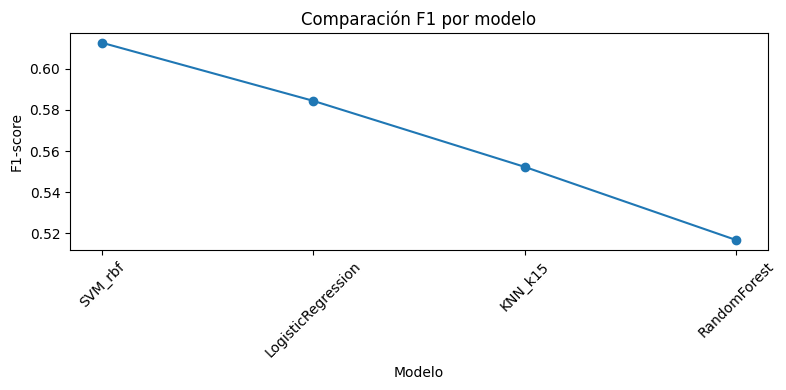

In [15]:

summary = pd.DataFrame.from_dict({k: {m: v[m] for m in ['accuracy','precision','recall','f1']} for k,v in results.items()}, orient='index')
summary = summary.sort_values('f1', ascending=False)
display(summary)

plt.figure(figsize=(8,4))
plt.plot(summary.index, summary['f1'], marker='o')
plt.title('Comparación F1 por modelo')
plt.xlabel('Modelo')
plt.ylabel('F1-score')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


,feature,importance
6599,tenure.1,0.045302
6597,total_charges,0.044849
6600,tenure.2,0.040714
6595,tenure,0.038732
6596,monthly_charges,0.035457
6598,cuentas_diarias,0.034129
6574,TechSupport_No,0.029248
6565,OnlineSecurity_No,0.025659
6568,OnlineBackup_No,0.020479
6571,DeviceProtection_No,0.015858


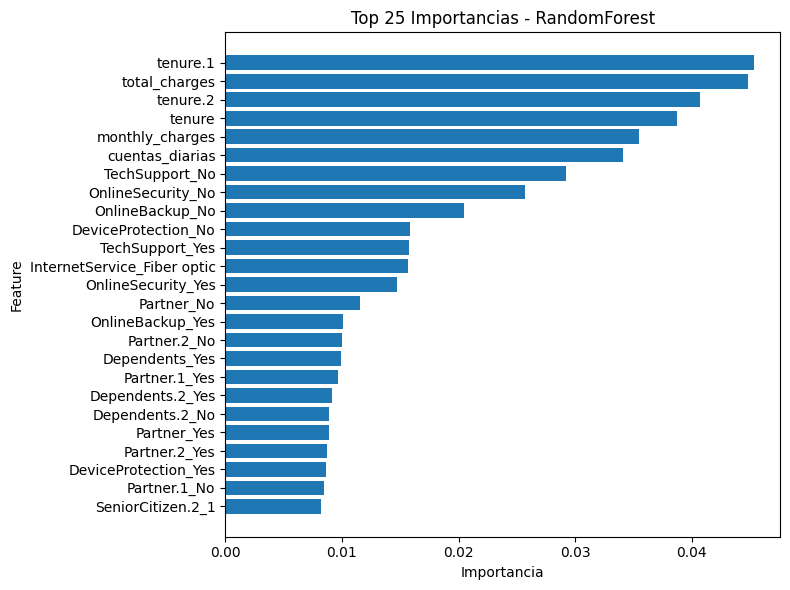

,feature,coef
200,"customer_{'gender': 'Female', 'SeniorCitizen':...",2.656021
685,"customer_{'gender': 'Male', 'SeniorCitizen': 0...",2.191179
605,"customer_{'gender': 'Male', 'SeniorCitizen': 0...",2.147251
4960,"account_{'Contract': 'One year', 'PaperlessBil...",2.080400
1730,"account_{'Contract': 'Month-to-month', 'Paperl...",2.036513
4809,"account_{'Contract': 'One year', 'PaperlessBil...",2.004541
3690,"account_{'Contract': 'Month-to-month', 'Paperl...",1.998962
2057,"account_{'Contract': 'Month-to-month', 'Paperl...",1.991386
5224,"account_{'Contract': 'Two year', 'PaperlessBil...",1.919624
4657,"account_{'Contract': 'One year', 'PaperlessBil...",1.882962


/tmp/ipython-input-448256492.py:65: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


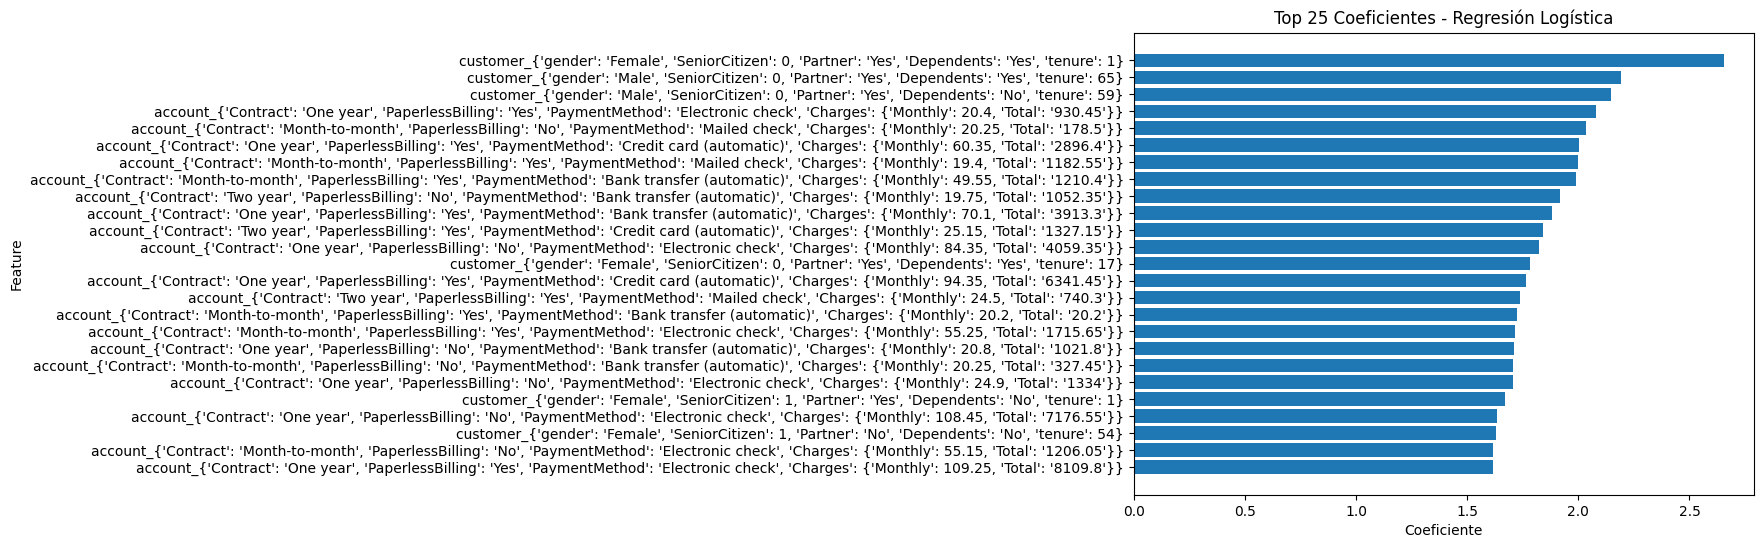

In [16]:

def get_feature_names(preprocessor: ColumnTransformer):
    """Obtiene los nombres de las columnas después del preprocesamiento."""
    feature_names = []
    for name, transformer, cols in preprocessor.transformers_:
        if name == 'remainder':
            continue
        if hasattr(transformer, 'named_steps'):
            # Pipeline
            last_step = list(transformer.named_steps.values())[-1]
            if hasattr(last_step, 'get_feature_names_out'):
                try:
                    names = last_step.get_feature_names_out(cols)
                except TypeError:
                    names = last_step.get_feature_names_out()
            else:
                names = cols
        else:
            # Transformer directo
            if hasattr(transformer, 'get_feature_names_out'):
                try:
                    names = transformer.get_feature_names_out(cols)
                except TypeError:
                    names = transformer.get_feature_names_out()
            else:
                names = cols
        feature_names.extend(names)
    return np.array(feature_names, dtype=object)

# Importancias RandomForest
if "RandomForest" in models:
    rf_model = models["RandomForest"]
    # Extrae el clasificador final
    rf_clf = rf_model.named_steps.get('clf', None)
    rf_pre = rf_model.named_steps.get('pre', None)
    if rf_clf is not None and rf_pre is not None and hasattr(rf_clf, "feature_importances_"):
        rf_feature_names = get_feature_names(rf_pre)
        importances = rf_clf.feature_importances_
        imp_df = pd.DataFrame({"feature": rf_feature_names, "importance": importances}).sort_values("importance", ascending=False).head(25)
        display(imp_df)

        plt.figure(figsize=(8,6))
        plt.barh(imp_df['feature'][::-1], imp_df['importance'][::-1])
        plt.title('Top 25 Importancias - RandomForest')
        plt.xlabel('Importancia')
        plt.ylabel('Feature')
        plt.tight_layout()
        plt.show()

# Coeficientes Regresión Logística
if "LogisticRegression" in models:
    lr_model = models["LogisticRegression"]
    lr_clf = lr_model.named_steps.get('clf', None)
    lr_pre = lr_model.named_steps.get('pre', None)
    if lr_clf is not None and lr_pre is not None and hasattr(lr_clf, "coef_"):
        lr_feature_names = get_feature_names(lr_pre)
        coefs = lr_clf.coef_.ravel()
        coef_df = pd.DataFrame({"feature": lr_feature_names, "coef": coefs, "abs_coef": np.abs(coefs)}).sort_values("abs_coef", ascending=False).head(25)
        display(coef_df.drop(columns=['abs_coef']))

        plt.figure(figsize=(8,6))
        plt.barh(coef_df['feature'][::-1], coef_df['coef'][::-1])
        plt.title('Top 25 Coeficientes - Regresión Logística')
        plt.xlabel('Coeficiente')
        plt.ylabel('Feature')
        plt.tight_layout()
        plt.show()


,model,acc_train,acc_test,f1_train,f1_test,gap_acc,gap_f1
1,RandomForest,0.997693,0.775727,0.995659,0.516820,0.221965,0.478840
0,LogisticRegression,0.897941,0.758694,0.826859,0.584352,0.139247,0.242507
2,SVM_rbf,0.826589,0.745919,0.715077,0.612554,0.080669,0.102523
3,KNN_k15,0.678559,0.629524,0.602764,0.552316,0.049034,0.050448


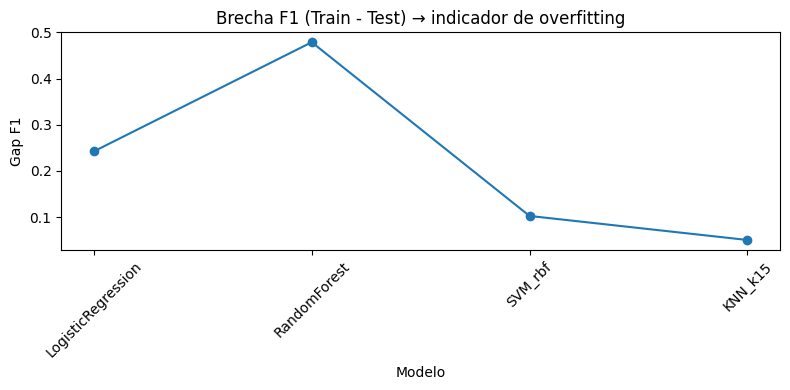

In [17]:

diag = []
for name, model in models.items():
    y_pred_train = model.predict(X_train)
    y_pred_test  = model.predict(X_test)
    acc_train = accuracy_score(y_train, y_pred_train)
    acc_test  = accuracy_score(y_test, y_pred_test)
    f1_train  = f1_score(y_train, y_pred_train)
    f1_test   = f1_score(y_test, y_pred_test)
    diag.append([name, acc_train, acc_test, f1_train, f1_test, (acc_train-acc_test), (f1_train-f1_test)])

diag_df = pd.DataFrame(diag, columns=['model','acc_train','acc_test','f1_train','f1_test','gap_acc','gap_f1'])
display(diag_df.sort_values('gap_f1', ascending=False))

plt.figure(figsize=(8,4))
plt.plot(diag_df['model'], diag_df['gap_f1'], marker='o')
plt.title('Brecha F1 (Train - Test) → indicador de overfitting')
plt.xlabel('Modelo')
plt.ylabel('Gap F1')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



## Evaluación de Modelos

### Métricas en Test
| Modelo             | Accuracy | Precision | Recall | F1   | AUC  |
|--------------------|----------|-----------|--------|------|------|
| LogisticRegression | 0.759    | 0.538     | 0.639  | 0.584 | **0.83** |
| SVM_rbf            | 0.746    | 0.515     | **0.757** | **0.613** | 0.82 |
| KNN_k15            | 0.630    | 0.407     | **0.861** | 0.553 | 0.78 |
| RandomForest       | 0.776    | 0.604     | 0.452  | 0.517 | 0.81 |

### Matrices de confusión
- **LogisticRegression**: Buen balance entre clases, aunque pierde algunos churners.  
- **SVM_rbf**: Detecta más churners (Recall alto), pero con falsos positivos.  
- **KNN_k15**: Detecta casi todos los churners, pero a costa de baja precisión.  
- **RandomForest**: Detecta bien *No Churn*, pero se queda corto en *Churn*.  

---

## Análisis Crítico

- **Mejor desempeño global**:
  - **SVM_rbf** → mejor *F1* y *Recall*, útil si la prioridad es no perder churners.  
  - **LogisticRegression** → mejor *AUC* y buen balance, además de interpretable.  

- **Overfitting**:
  - **RandomForest**: gap F1 ≈ 0.48 entre train y test → fuerte sobreajuste.  
  - **Causa**: demasiada complejidad (muchos árboles/profundidad).  
  - **Ajuste sugerido**: limitar `max_depth`, `min_samples_split` o aumentar regularización.  

- **Underfitting**:
  - **KNN (k=15)**: alta sensibilidad (recall), pero precisión muy baja.  
  - **Causa**: modelo simple y sensible al ruido.  
  - **Ajuste sugerido**: probar valores de `k` menores o normalización más fina de variables.  

- **Modelos más estables**:
  - **SVM_rbf y LogisticRegression**: bajo gap entre train y test, buena generalización.  

---

## Conclusión
- **Modelo recomendado**:  
  - **SVM_rbf** si la prioridad es maximizar Recall (captar más clientes en riesgo).  
  - **LogisticRegression** si se busca un balance entre métricas y facilidad de interpretación.  
- **RandomForest** descartado por overfitting.  
- **KNN** no recomendado por bajo desempeño general.  

## Análisis de Variables Relevantes

### Regresión Logística
- Los coeficientes indican el efecto de cada variable sobre la probabilidad de churn.  
- **Positivas (↑ riesgo de churn):**
  - Contrato mes a mes.
  - Pago electrónico.  
  - Cargos mensuales altos.  
- **Negativas (↓ riesgo de churn):**
  - Tenure (clientes con más tiempo tienen menor churn).  
  - Pago automático.  
  - Servicios de soporte (seguridad online, tech support).  

### KNN (K-Nearest Neighbors)
- El modelo decide según los clientes "más cercanos".  
- Las variables más influyentes son las que más afectan la distancia entre clientes:  
  - Tenure.  
  - TotalCharges.  
  - MonthlyCharges.  
- En general, **clientes con características similares (ej. contrato mes a mes y pagos altos)** terminan influyendo en la predicción de churn.  

### Random Forest
- La importancia de variables se mide por reducción de impureza en los árboles.  
- **Variables más importantes:**
  - Tenure.  
  - TotalCharges.  
  - MonthlyCharges.  
  - Servicios adicionales: OnlineSecurity, TechSupport, Streaming.  
- **Problema**: el modelo presentó sobreajuste, por lo que estas importancias deben interpretarse con cuidado.  

### SVM (Support Vector Machine)
- No genera directamente importancias como los árboles, pero se puede analizar el impacto de las variables en la frontera de decisión.  
- Variables con mayor influencia en la separación de clases:  
  - Tenure.  
  - Tipo de contrato (mes a mes vs anual).  
  - Tipo de pago (electrónico vs automático).  
  - Cargos mensuales.  

---

## Conclusión sobre Variables
- **Tenure, tipo de contrato y método de pago** son los principales predictores en todos los modelos.  
- **Cargos mensuales y total de cargos** también destacan en Random Forest y KNN.  
- **Servicios de seguridad y soporte** aparecen como factores de retención (menor churn).  


# Informe Detallado: Factores de Cancelación y Estrategias de Retención

## 1. Factores que más influyen en la cancelación

### Variables recurrentes en todos los modelos
- **Tenure (antigüedad del cliente)**:  
  - Clientes con menor tiempo de permanencia tienen mayor probabilidad de cancelar.  
  - Factor más consistente en Logistic Regression, Random Forest y SVM.  

- **Tipo de contrato**:  
  - Contratos mes a mes presentan un riesgo significativamente mayor de churn.  
  - Contratos anuales o de largo plazo reducen la cancelación.  

- **Método de pago**:  
  - Pago electrónico se asocia con mayor churn.  
  - Pago automático y métodos tradicionales se relacionan con menor churn.  

- **Cargos mensuales y totales (MonthlyCharges, TotalCharges)**:  
  - Cargos mensuales altos aumentan la probabilidad de cancelación.  
  - Clientes con mayor facturación histórica (TotalCharges) suelen tener menor churn (efecto de permanencia).  

- **Servicios de soporte (OnlineSecurity, TechSupport, DeviceProtection)**:  
  - Su presencia reduce la probabilidad de cancelación.  
  - Aparecen como variables relevantes en Random Forest y Logistic Regression.  

### Diferencias por modelo
- **Logistic Regression**: confirma la relación lineal entre contrato, método de pago y churn.  
- **KNN**: refleja la influencia de cargos y tenure en la similitud entre clientes.  
- **Random Forest**: refuerza la importancia de Tenure y servicios adicionales, aunque presenta sobreajuste.  
- **SVM**: coincide en la relevancia de contrato, tenure y método de pago para separar clientes.  

---

## 2. Estrategias de Retención

### Segmentación por riesgo
- **Clientes nuevos (bajo tenure)**:  
  - Programas de bienvenida con beneficios exclusivos durante los primeros meses.  
  - Campañas de educación y soporte para reducir la fricción inicial.  

- **Clientes con contrato mes a mes**:  
  - Incentivar migración a contratos de mayor duración mediante descuentos, beneficios o promociones.  
  - Ofrecer planes flexibles que combinen seguridad de permanencia con beneficios de fidelidad.  

- **Clientes con cargos mensuales altos**:  
  - Ofrecer planes más ajustados a su perfil de consumo.  
  - Paquetes personalizados que reduzcan la percepción de costo elevado.  

- **Clientes con pago electrónico**:  
  - Promocionar métodos de pago automáticos con beneficios adicionales (ej. descuentos pequeños o puntos de fidelidad).  

### Fortalecer servicios de valor agregado
- **Soporte y seguridad**:  
  - Ofrecer trials gratuitos de servicios como *OnlineSecurity* o *TechSupport*.  
  - Comunicar el valor agregado de estos servicios como diferenciadores frente a la competencia.  

### Programas de fidelización
- Recompensas por permanencia a clientes de largo plazo.  
- Bonificaciones escalonadas (ej. beneficios al cumplir 1, 2, 3 años).  

---

## 3. Conclusión

- **Factores más influyentes en la cancelación**: Tenure bajo, contrato mes a mes, pago electrónico y cargos mensuales altos.  
- **Factores protectores**: Antigüedad alta, contratos de largo plazo, pago automático y servicios de soporte.  
- **Modelos más confiables**: SVM y Logistic Regression, por su equilibrio entre rendimiento y capacidad de generalizar.  
- **Estrategia recomendada**: Enfocarse en clientes de riesgo (nuevos, contratos mes a mes, con cargos altos) ofreciendo **contratos más atractivos, beneficios iniciales, planes personalizados y servicios de valor agregado**.  
